In [1]:
!apt-get update

!apt-get install gfortran -y

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,240 kB]
Get:14 https://r2u.stat.i

In [ ]:
# upload /Python/Section3_changepoints/simulation_file for LRTS simulations analysis
from google.colab import files
uploaded = files.upload()
import shutil
for filename in uploaded.keys():
    shutil.move(filename, filename)

In [ ]:
!gfortran -o etas etas.f

etas.f:151:72:

  151 |    10 xmg(i)=xmg(i)-xmag0
      |                                                                        1
etas.f:154:72:

  154 |    60 x(i)=xini(i)
      |                                                                        1
etas.f:159:72:

  159 |    70 x(i)=sqrt(x(i))
      |                                                                        1
etas.f:170:72:

  170 |    80 x(i)=x(i)**2
      |                                                                        1
etas.f:225:72:

  225 |    10 h(i,j) = 0.0d00
      |                                                                        1
etas.f:228:72:

  228 |    20 h(i,i) = 1.0d00
      |                                                                        1
etas.f:243:72:

  243 |    40 y(i) = g(i) - g0(i)
      |                                                                        1
etas.f:247:72:

  247 |    50 sum = sum + y(j) * h(i,j)
      |                                              

In [ ]:
!./etas

           9           2
   0.0000000000000000        3653.8510300925900        5.0099999999999998     
   3.6000000000000001        7.2000000000000002     
       minmag, dep1, ts, tend,tstart
      3.600     0.000  3653.851     5.010
1	120.84	23.18	4.1	0	-4.2	2014	6	20                                             
      1      1     3.60000     0.85564   -47.70000
      2      2     4.30000     2.77861   -18.70000
      3      3     3.70000     5.65655   -28.40000
      4      4     3.90000     6.34677    -9.70000
      5      5     4.00000     9.26355   -39.70000
      6      6     4.20000    10.51832   -23.90000
      7      7     4.30000    12.21912   -32.20000
      8      8     4.00000    12.23260   -31.80000
      9      9     4.00000    12.37890   -16.10000
     10     10     3.60000    13.50611   -31.80000
     11     11     3.70000    15.11300   -34.70000
     12     12     3.90000    17.74815   -12.90000
     13     13     3.70000    17.95466   -40.60000
     14     14     5

In [ ]:
import numpy as np
import re
import os
import subprocess
def load_simulated_data(file_path):
    """
    Load simulated data from a file, handling potential issues with inconsistent column counts.

    Parameters:
    - file_path: str, the path to the file to be loaded.

    Returns:
    - np.ndarray or None: The loaded data as a NumPy array, or None if an error occurs.
    """
    try:
        # Use genfromtxt to load the data, handling cases where the file might be malformed.
        data = np.genfromtxt(file_path, skip_header=1, invalid_raise=False)
        return data
    except ValueError as e:
        print(f"Error loading {file_path}: {e}")
        return None

def write_etas_open(filename, zts, zte, tarst, params_values):
    """
    Write the etas.open file with the required format using provided start time, end time, duration, and custom parameters.
    """
    content = f"""9 2
{zts:.3f} 3653.85103009259 {tarst:.2f}
3.6 7.2
{params_values}
{zts:.3f} {zte:.3f} {tarst:.2f}
3.6 7.2
-0.4753056E+04
{params_values}
"""
    with open(filename, 'w') as f:
        f.write(content)


def extract_values(fortran_output):
    """
    Extract the log-likelihood and AIC values from the Fortran output.
    The log-likelihood is multiplied by -1 to convert from negative to positive.
    """
    log_likelihood = None
    aic = None

    # Update the regular expression to match numbers in scientific notation
    ll_match = re.search(r'neg max lklhd=\s*([-+]?\d*\.\d+[Ee][-+]?\d+|\d+)', fortran_output)
    if ll_match:
        log_likelihood = -1 * float(ll_match.group(1))  # Convert to positive log-likelihood

    # Extract AIC using a similar regular expression
    aic_match = re.search(r'aic/2\s*=\s*([-+]?\d*\.\d+[Ee][-+]?\d+|\d+)', fortran_output)
    if aic_match:
        aic_half = float(aic_match.group(1))
        aic = aic_half * 2  # Multiply by 2 to get the full AIC value

    return log_likelihood, aic

def run_etas_mle(input_file, control_file, output_file):
    """
    Run the Fortran MLE calculation program using the IPython `!` operator,
    and capture the output to extract log-likelihood and AIC values.
    """
    # Run the Fortran program using the `!` operator
    fortran_output = !./etas {input_file} {control_file}

    # Convert the captured output to a single string
    fortran_output = "\n".join(fortran_output)

    # Write the output to the specified file for further inspection
    with open(output_file, 'w') as f:
        f.write(fortran_output)

    # Extract the log-likelihood and AIC values
    log_likelihood, aic = extract_values(fortran_output)

    # Debugging: Print the extracted values
    print(f"Extracted Log-Likelihood: {log_likelihood}")
    print(f"Extracted AIC: {aic}")

    return log_likelihood, aic


def split_simulated_data(simulated_data, change_points):
    segments = []
    segments.append(simulated_data[:change_points[0]])
    for i in range(1, len(change_points)):
        start = change_points[i - 1]
        end = change_points[i]
        segment = simulated_data[start:end]
        segments.append(segment)
    segments.append(simulated_data[change_points[-1]:])
    return segments

def calculate_lrts(log_likelihood_A, log_likelihood_B):
    """
    Calculate the Likelihood Ratio Test Statistic (LRTS).

    The LRTS is calculated as:
        LRTS = -2 * (log_likelihood_A - log_likelihood_B)

    Parameters:
    - log_likelihood_A: float, the log-likelihood of model A (single-stage model).
    - log_likelihood_B: float, the sum of log-likelihoods of the segments in the multistage model (model B).

    Returns:
    - float: The Likelihood Ratio Test Statistic (LRTS).
    """
    return -2 * (log_likelihood_A - log_likelihood_B)

In [ ]:
l_a=0.1781931E+04
l_b = -0.3708756E+03-0.8698350E+03+0.4585403E+02+0.3117043E+04

Q_obs=-2*(l_a-l_b)
print(Q_obs)

280.51085999999987


In [ ]:
change_points = [846, 1352, 2377] #sequence number of the change points
lrts_simulated = []
# Initial parameter values for each segment
segment_params_values = [
    '0.214 1.724 0.003 1.193 1.069',
    '0.293 0.256 0.002 0.861 1.024',
    '0.140 3.508 0.001 1.514 0.983',
    '0.154 2.522 0.009 1.181 1.210'
]

# Process the pre-generated simulated datasets
num_simulations = 30

for i in range(num_simulations):
    simulated_data = load_simulated_data(f"work_{i+1}.etasim")
    if simulated_data is None or len(simulated_data) == 0:
        print(f"Skipping simulation {i} due to read error or empty data.")
        continue
    # Full MLE for entire simulated dataset
    segment_file = f"simulated_work_{i}.etas"
    fmt = '%d ' + ' '.join(['%f'] * (simulated_data.shape[1] - 1))

    np.savetxt(segment_file, simulated_data, fmt=fmt)

    # Rename to work.etas for processing
    os.rename(segment_file, "work.etas")
    log_likelihood_A_sim, aic_A_sim = run_etas_mle("etas.open", "work.etas", f"mle_a_sim_{i}.out")
    os.rename("work.etas", segment_file)

    segments = split_simulated_data(simulated_data, change_points)
    total_log_likelihood_B_sim = 0

    for j, segment in enumerate(segments):
        zts = segment[0, 4]  # Start time of the segment
        zte = segment[-1, 4]  # End time of the segment
        tarst = zts+0.01

        # Use the pre-defined parameter values for this segment
        params_values = segment_params_values[j]
        # Write the etas.open file for the segment with these parameters
        write_etas_open("etas.open", zts, zte, tarst, params_values)
        # Save the segment data to a work file
        segment_file = f"simulated_segment_{i}_{j}.etas"
        fmt = '%d ' + ' '.join(['%f'] * (segment.shape[1] - 1))
        np.savetxt(segment_file, segment, fmt=fmt)
        # Rename to work.etas for processing
        os.rename(segment_file, "work.etas")

        # Run MLE for this segment
        log_likelihood_B_sim, aic_B_sim = run_etas_mle("etas.open", "work.etas", f"mle_b_sim_{i}_{j}.out")
        total_log_likelihood_B_sim += log_likelihood_B_sim

        os.rename("work.etas", segment_file)

    Q_k = calculate_lrts(log_likelihood_A_sim, total_log_likelihood_B_sim)
    lrts_simulated.append(Q_k)

# Save LRTS results to a file for further analysis
np.savetxt("lrts_results.txt", lrts_simulated)

# Calculate p-value
p_value = np.sum(np.array(lrts_simulated) >= Q_obs) / num_simulations
print(f"Observed LRTS: {Q_obs}")
print(f"P-value: {p_value}")

Extracted Log-Likelihood: -181.6867
Extracted AIC: 373.3734738
Extracted Log-Likelihood: -572.2908
Extracted AIC: 1154.5815354
Extracted Log-Likelihood: -211.8762
Extracted AIC: 433.7524086
Extracted Log-Likelihood: 220.8712
Extracted AIC: -431.7424736
Extracted Log-Likelihood: 359.0975
Extracted AIC: -708.194976
Extracted Log-Likelihood: -2.758803
Extracted AIC: 15.517605442
Extracted Log-Likelihood: -584.3493
Extracted AIC: 1178.6985028
Extracted Log-Likelihood: -194.4538
Extracted AIC: 398.9076856
Extracted Log-Likelihood: 341.4619
Extracted AIC: -672.9238006
Extracted Log-Likelihood: 552.7407
Extracted AIC: -1095.481455
Extracted Log-Likelihood: 188.5036
Extracted AIC: -367.0071964
Extracted Log-Likelihood: -679.1495
Extracted AIC: 1368.2989506
Extracted Log-Likelihood: -207.7341
Extracted AIC: 425.4681862
Extracted Log-Likelihood: 340.6473
Extracted AIC: -671.294562
Extracted Log-Likelihood: 241.5073
Extracted AIC: -473.014642
Extracted Log-Likelihood: -194.6599
Extracted AIC: 399

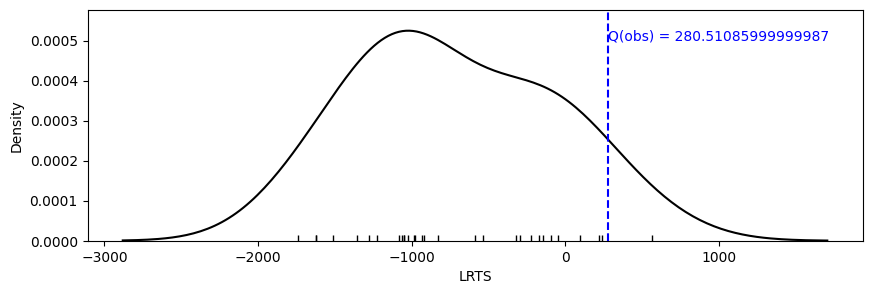

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
sns.kdeplot(lrts_simulated, bw_adjust=1.2, color='black')

# Add the observed LRTS line
plt.axvline(Q_obs, color='blue', linestyle='--')
plt.text(Q_obs, 0.0005, f'Q(obs) = {Q_obs}', color='blue')

# Add rugplot for individual LRTS values
sns.rugplot(lrts_simulated, color='black')

plt.xlabel('LRTS')
plt.ylabel('Density')
plt.savefig('lrt_kde_plot.png', dpi=300, bbox_inches='tight')
plt.show()